In [15]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Model running via: {device}")

Model running via: cuda


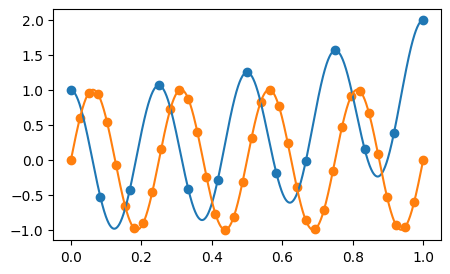

In [17]:
# Globally Shared Model(s) Parameters
lf_num_epochs = 400
hf_num_epochs = 600
MF_epochs = 600

hidden_dims = ([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])
LF_training_size = 40
HF_training_size = 13


# # # Synthetic data function..
# def LF(x):
#     return torch.sin(x * (6 * torch.pi))*x
    
# def HF(x): 
#     return 1.8*torch.sin(x * (6 * torch.pi))*2*x 

# Complex Synthetic Data
def LF(y):
    return np.sin(8 * np.pi * y)

def HF(y):
    return y**2 + LF(y + np.pi/10)


# Run this through the model to get the black prediction line (predictionu bundan al)
Z = torch.linspace(0, 1, 1000)[:,None]

# Model's total training/val/testing dataset
LF_TS = torch.linspace(0, 1, LF_training_size)[:,None]
HF_TS = torch.linspace(0, 1, HF_training_size)[:,None]

# Forming LF Test Sets with a neat trick
X_LF_train, X_LF_test, Y_LF_train, Y_LF_test = train_test_split(LF_TS, LF(LF_TS), test_size=0.8, shuffle=156)
X_HF_train, X_HF_test, Y_HF_train, Y_HF_test = train_test_split(HF_TS, HF(HF_TS), test_size=0.8, shuffle=156)

# Forming the real equally spaced training sets
X_LF_train = LF_TS
Y_LF_train = LF(LF_TS) 

X_HF_train = HF_TS
Y_HF_train = HF(HF_TS)

plt.figure(figsize=(5,3))
plt.plot(Z ,HF(Z))
plt.plot(Z ,LF(Z))
plt.scatter(X_HF_train, Y_HF_train)
plt.scatter(X_LF_train, Y_LF_train)

# Transfering data to GPU for CUDA
X_LF_train = X_LF_train.to(device); Y_LF_train = Y_LF_train.to(device)
X_HF_train = X_HF_train.to(device); Y_HF_train = Y_HF_train.to(device)

X_LF_test = X_LF_test.to(device); Y_LF_test = Y_LF_test.to(device)
X_HF_test = X_HF_test.to(device); Y_HF_test = Y_HF_test.to(device)

Low Fidelity Network

In [18]:
LF_input_dim = 1
LF_output_dim = 1

class LowFidelityNetwork(torch.nn.Module):
  def __init__(self, hidden_dims, LF_input_dim, LF_output_dim):
    super().__init__()
    self.fc1 = nn.Linear(LF_input_dim, hidden_dims[0])
    # self.bn1 = nn.BatchNorm1d(hidden_dims[0])
    self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
    self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
    self.fc4 = nn.Linear(hidden_dims[2], hidden_dims[3])
    self.fc5 = nn.Linear(hidden_dims[3], hidden_dims[4])
    self.fc6 = nn.Linear(hidden_dims[4], hidden_dims[5])
    self.fc7 = nn.Linear(hidden_dims[5], hidden_dims[6])
    self.fcEND = nn.Linear(hidden_dims[6], LF_output_dim)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    skip_connection = x
    # x = self.bn1(x)
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.relu(self.fc6(x))
    x = torch.relu(self.fc7(x))
    x = x + skip_connection
    x = self.fcEND(x)
    return x

LF_model = LowFidelityNetwork(hidden_dims, LF_input_dim, LF_output_dim).to(device)

for param in LF_model.parameters():
    param.requires_grad = True

In [19]:
LF_model.train()

# Training
LF_losses = [] 
val_losses = []
prev_loss = []
LF_loss = torch.zeros(1)

LF_batch_size = 100

# LF_loss criterion and optimizer
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(LF_model.parameters(), lr=0.0005) # weight_decay=1e-5


for epoch in range(lf_num_epochs):
    
    permutation = torch.randperm(X_LF_train.size()[0])
    
    for i in range(0,X_LF_train.size()[0], LF_batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+LF_batch_size]
        batch_x, batch_y = X_LF_train[indices], Y_LF_train[indices]
    
        prev_loss = LF_loss.item()
        outputs = LF_model.forward(batch_x)
        LF_loss = criterion(outputs,batch_y)
        LF_losses.append(LF_loss.item())
        LF_loss.backward()
        optimizer.step()

    if (epoch+1) % 600 == 0:
        print(f'Epoch [{epoch+1}/{hf_num_epochs}], Loss: {LF_loss.item():.4f}')

Epochs needed (out of 400): 400
LF Training Loss: 1.0727020480771898e-06


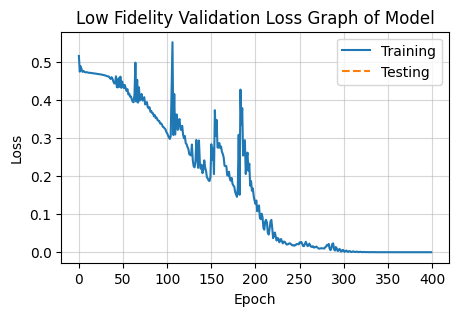

In [20]:
plt.figure(figsize=(5,3))
plt.plot(LF_losses, label = "Training")
plt.xlabel('Epoch')
plt.ylabel('LF_Loss')
plt.title('Low Fidelity Training Loss Graph of Model')

plt.plot(val_losses, "--" , label = "Testing")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Low Fidelity Validation Loss Graph of Model')
plt.grid(which='both', alpha=0.5)
plt.legend(loc='upper right')
# plt.show()

print(f"Epochs needed (out of {lf_num_epochs}): {len(LF_losses)}")
print(f"LF Training Loss: {LF_loss}")

High Fidelity Model

In [21]:
HF_input_dim = 1
HF_output_dim = 1

class HighFidelityNetwork(torch.nn.Module):
  def __init__(self, hidden_dims, HF_input_dim, HF_output_dim):
    super().__init__()
    self.fc1 = nn.Linear(HF_input_dim, hidden_dims[0])
    # self.bn1 = nn.BatchNorm1d(hidden_dims[0])
    self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
    self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
    self.fc4 = nn.Linear(hidden_dims[2], hidden_dims[3])
    self.fc5 = nn.Linear(hidden_dims[3], hidden_dims[4])
    self.fc6 = nn.Linear(hidden_dims[4], hidden_dims[5])
    self.fc7 = nn.Linear(hidden_dims[5], hidden_dims[6])
    self.fcEND = nn.Linear(hidden_dims[7], HF_output_dim)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    # x = self.bn1(x)
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.relu(self.fc6(x))
    x = torch.relu(self.fc7(x))
    x = self.fcEND(x)
    return x

HF_model = HighFidelityNetwork(hidden_dims, HF_input_dim, HF_output_dim).to(device)

for param in HF_model.parameters():
    param.requires_grad = True

In [22]:
HF_model.train()

# Training
HF_losses = [] 
val_losses = []
prev_loss = []
HF_loss = torch.zeros(1)

HF_batch_size = 45

# HF_loss criterion and optimizer
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(HF_model.parameters(), lr=0.0005, weight_decay=1e-4) # weight_decay=1e-5

for epoch in range(hf_num_epochs):
    
    permutation = torch.randperm(X_HF_train.size()[0])
    
    for i in range(0,X_HF_train.size()[0], HF_batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+HF_batch_size]
        batch_x, batch_y = X_HF_train[indices], Y_HF_train[indices]
    
        prev_loss = HF_loss.item()
        outputs = HF_model.forward(batch_x)
        HF_loss = criterion(outputs,batch_y)
        HF_losses.append(HF_loss.item())
        HF_loss.backward()
        optimizer.step()
        
    if (epoch+1) % 600 == 0:
        print(f'Epoch [{epoch+1}/{hf_num_epochs}], Loss: {HF_loss.item():.4f}')



Epoch [600/600], Loss: 0.0001


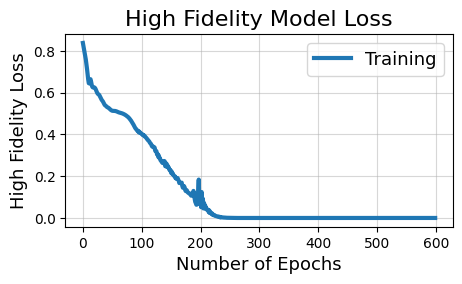

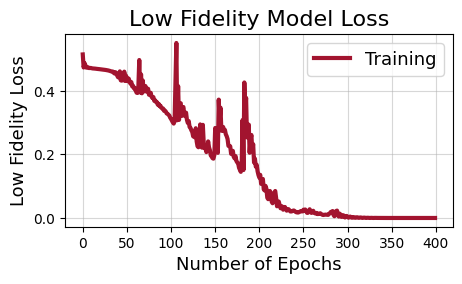

Epochs needed (out of 600): 600
HF Training Loss: 7.413553248625249e-05


In [23]:
plt.figure(figsize=(5,2.5))
plt.plot(HF_losses, label = "Training",lw=3)

plt.xlabel('Number of Epochs', fontsize = 13)
plt.ylabel('Loss', fontsize = 13)
plt.title('NN Model Loss', fontsize = 16)
plt.legend(loc='upper right', fontsize = 13)
plt.grid(which='both', alpha=0.5)
plt.show()

plt.figure(figsize=(5,2.5))
plt.plot(LF_losses,color=(0.6350, 0.0780, 0.1840), label = "Training",lw=3, )

plt.xlabel('Number of Epochs', fontsize = 13)
plt.ylabel('Low Fidelity Loss', fontsize = 13)
plt.title('Low Fidelity Model Loss', fontsize = 16)
plt.legend(loc='upper right', fontsize = 13)
plt.grid(which='both', alpha=0.5)
plt.show()

# print(f"Error: {HF_average_percentage_error}")
print(f"Epochs needed (out of {hf_num_epochs}): {len(HF_losses)}")
print(f"HF Training Loss: {HF_loss}")

Multi-Fidelity Model

In [24]:
embedding = 0.43
L1mean = LF_model(X_HF_train.to(device))
L1mean_up= LF_model(X_HF_train.to(device)+embedding)
L1mean_dn = LF_model(X_HF_train.to(device)-embedding)

L2train = torch.hstack((X_HF_train, L1mean, L1mean_up, L1mean_dn)) # think of the house price example (sqr feet, rooms, garden, etc.)
print(L2train.shape)

torch.Size([13, 4])


In [25]:
MF_input_dim = 4
MF_output_dim = 1

class MultiFidelityNetwork(torch.nn.Module):
  def __init__(self, hidden_dims, MF_input_dim, MF_output_dim):
    super().__init__()
    self.fc1 = nn.Linear(MF_input_dim, hidden_dims[0])
    
    self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
    self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
    self.fc4 = nn.Linear(hidden_dims[2], hidden_dims[3])
    self.fc5 = nn.Linear(hidden_dims[3], hidden_dims[4])
    self.fc6 = nn.Linear(hidden_dims[4], hidden_dims[5])
    self.fc7 = nn.Linear(hidden_dims[5], hidden_dims[6])
    self.fcEND = nn.Linear(hidden_dims[6], MF_output_dim)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.relu(self.fc6(x))
    x = torch.relu(self.fc7(x))
    x = self.fcEND(x)
    return x

MF_model = MultiFidelityNetwork(hidden_dims, MF_input_dim, MF_output_dim).to(device)

for param in MF_model.parameters():
    param.requires_grad = True

In [26]:
HF_model.train()

# Training
MF_losses = [] 
val_losses = []
prev_loss = []
MF_loss = torch.zeros(1)

# MF_loss criterion and optimizer
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(MF_model.parameters(), lr=0.00005) # weight_decay=1e-5

for epoch in range(MF_epochs):

    # Training
    prev_loss = MF_loss.item()
    MF_y_pred = MF_model(L2train)
    MF_loss = criterion(MF_y_pred, Y_HF_train)
    MF_losses.append(MF_loss.item())
    optimizer.zero_grad()
    MF_loss.backward(retain_graph=True)
    optimizer.step()

    if (epoch+1) % 300 == 0:
        print(f'Epoch [{epoch+1}/{MF_epochs}], Loss: {MF_loss.item():.4f}')

Epoch [300/600], Loss: 0.0000
Epoch [600/600], Loss: 0.0000


MF Training Loss: 5.619146259405738e-10


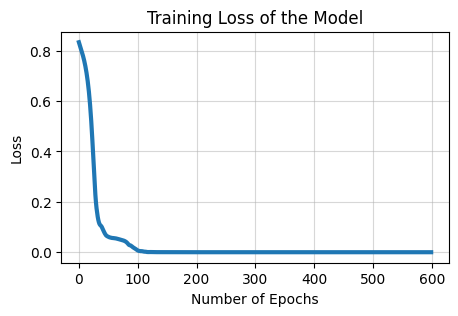

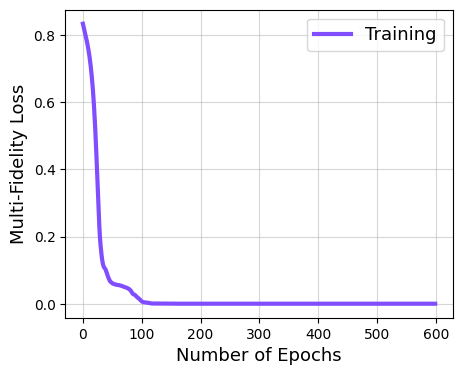

In [35]:
plt.figure(figsize=(5,3))
plt.plot(MF_losses,lw=3)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training Loss of the Model')
plt.grid(which='both', alpha=0.5)
print(f"MF Training Loss: {MF_loss}")

plt.figure(figsize=(5,4))
plt.plot(MF_losses,color=(0.5,0.3, 1), label = "Training",lw=3)

plt.xlabel('Number of Epochs', fontsize = 13)
plt.ylabel('Multi-Fidelity Loss', fontsize = 13)
plt.legend(loc='upper right', fontsize = 13)
plt.grid(which='both', alpha=0.5)
plt.show()

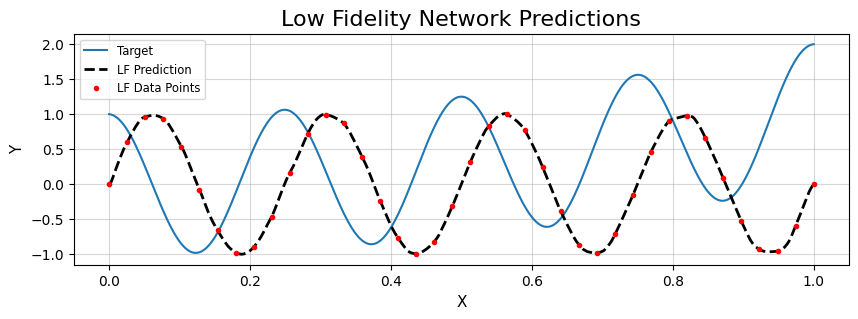

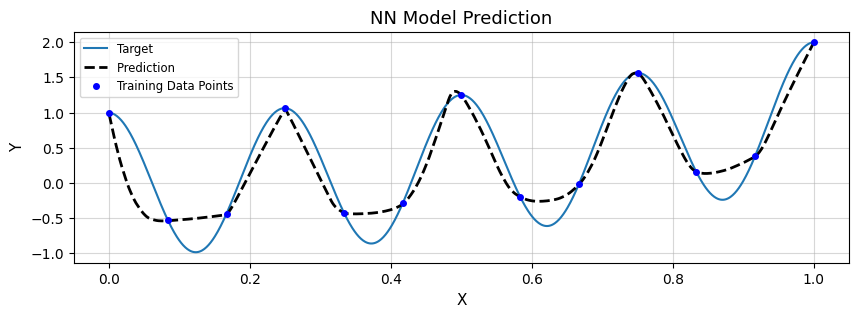

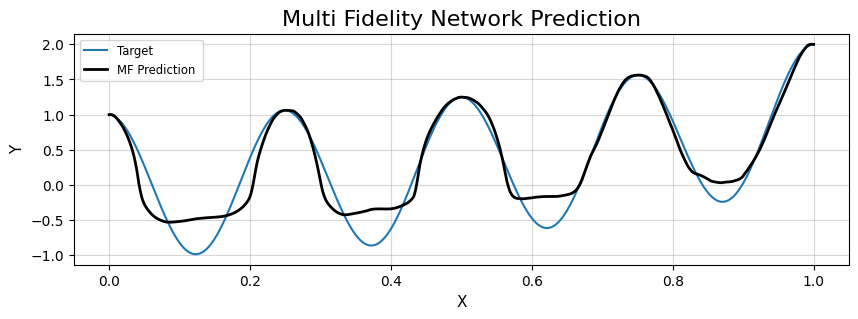

In [29]:
# Put models
LF_model.eval()
HF_model.eval()
MF_model.eval()

empty = torch.zeros(1000,1).to(device)

# Define the NEW input data
with torch.no_grad(): 
    y_LF_pred = LF_model(Z.to(device))
    y_LF_pred_up = LF_model(Z.to(device)+embedding)
    y_LF_pred_dn = LF_model(Z.to(device)-embedding)
    y_HF_pred = HF_model(Z.to(device)) 
    
    # Step 4: Add X and output of the LF model (similar to Step 2)
    L2test = torch.hstack((Z.to(device), y_LF_pred,  y_LF_pred_up,  y_LF_pred_dn))
    y_MF_pred = MF_model(L2test.to(device)) 
    

# Data Point Distribution
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(Z, HF(Z), label= "Target ")
ax.grid(which='both', alpha=0.5)
ax.set_xlabel('X', fontsize=11)
ax.set_ylabel('Y', fontsize=11)
ax.set_title('Low Fidelity Network Predictions', fontsize=16)
ax.plot(Z.cpu().detach().numpy(), y_LF_pred.cpu().detach().numpy(),'--k', lw=2, label= "LF Prediction ")
ax.plot(X_LF_train.cpu().detach().numpy(), Y_LF_train.cpu().detach().numpy(), 'ro', markersize = 3, label = 'LF Data Points')

ax.legend(loc='upper left', ncol=1, fontsize='small')
plt.show()


fig, ax = plt.subplots(figsize=(10,3))
ax.plot(Z, HF(Z), label= "Target ")
ax.plot(Z.cpu().detach().numpy(), y_HF_pred.cpu().detach().numpy(),'--k', lw=2, label= "Prediction ")
ax.plot(X_HF_train.cpu().detach().numpy(), Y_HF_train.cpu().detach().numpy(), 'bo', markersize = 4, label = 'Training Data Points')
ax.grid(which='both', alpha=0.5)
ax.set_xlabel('X', fontsize=11)
ax.set_ylabel('Y', fontsize=11)
ax.legend(loc='upper left', ncol=1, fontsize='small')
ax.set_title('NN Model Prediction', fontsize=13)
plt.show()



fig, ax = plt.subplots(figsize=(10,3))
ax.plot(Z, HF(Z), label= "Target")
ax.plot(Z.cpu().detach().numpy(), y_MF_pred.cpu().detach().numpy(),'k', lw=2, label= "MF Prediction ")
ax.grid(which='both', alpha=0.5)
ax.set_xlabel('X', fontsize=11)
ax.set_ylabel('Y', fontsize=11)
ax.set_title('Multi Fidelity Network Prediction', fontsize=16)
ax.legend(loc='upper left', ncol=1, fontsize='small')
plt.show()
